In [116]:
import sys
#!{sys.executable} -m pip install wordcloud
#!{sys.executable} -m pip install xgboost
#!{sys.executable} -m pip install nltk
#!{sys.executable} -m pip install textblob




In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
#nltk.download('all')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from nltk.corpus import stopwords
from textblob import TextBlob
import plotly.figure_factory as ff
url = 'https://raw.githubusercontent.com/breanna-s/Mental-Health-Chatbot/refs/heads/main/Combined%20Data.csv'
df = pd.read_csv(url)
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [118]:
df.isnull().sum()


Unnamed: 0      0
statement     362
status          0
dtype: int64

In [119]:
df.dropna(how='any', axis=0, inplace=True)
df.isnull().sum()

Unnamed: 0    0
statement     0
status        0
dtype: int64

In [120]:
# Counts for each Mental Health status
df["status"].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

In [121]:
# get number of characters as this will be ussed to eliminate outliers later
df['num_chars'] = df['statement'].str.len()
print(df['num_chars'].describe())

count    52681.000000
mean       578.713863
std        846.269078
min          2.000000
25%         80.000000
50%        317.000000
75%        752.000000
max      32759.000000
Name: num_chars, dtype: float64


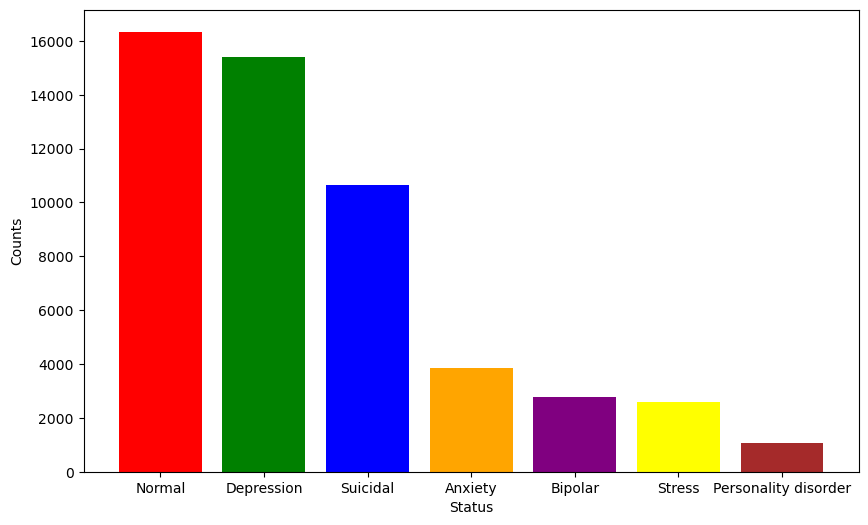

In [122]:
# Visualization of distribution of each Mental Health Status
s_count = df["status"].value_counts()
colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'brown'] 

plt.figure(figsize=(10,6))
plt.bar(s_count.index, s_count.values, color=colors[:len(s_count)])
plt.xlabel("Status")
plt.ylabel("Counts")
plt.show()

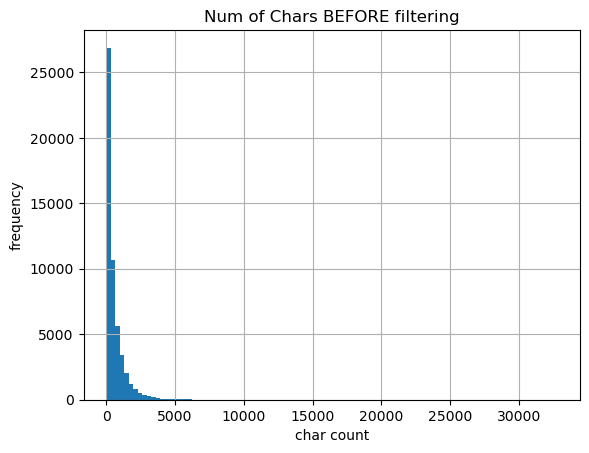

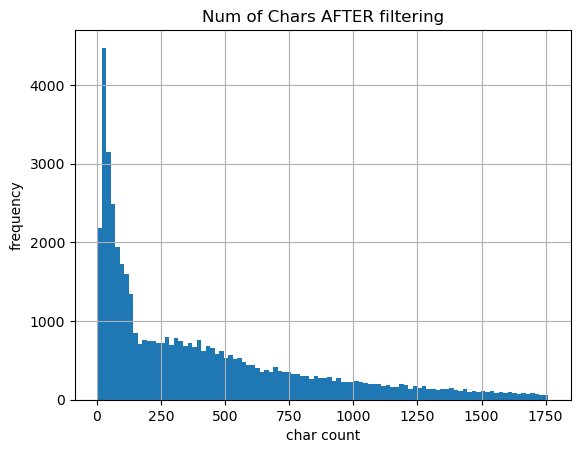

,Unnamed: 0,num_chars
count,52681.000000,52681.000000
mean,26365.706042,578.713863
std,15235.065306,846.269078
min,0.000000,2.000000
25%,13180.000000,80.000000
50%,26350.000000,317.000000
75%,39522.000000,752.000000
max,53042.000000,32759.000000


In [123]:
#remove outliers of the lower quarter percentile and upper quarter percentile of the number of characters

df['num_chars'].hist(bins=100)
plt.title('Num of Chars BEFORE filtering')
plt.xlabel('char count')
plt.ylabel('frequency')
plt.show()



lower_q = df['num_chars'].quantile(.25)
upper_q = df['num_chars'].quantile(.75)
q_range = upper_q - lower_q

lower_bound = lower_q - 1.5 * q_range
upper_bound = upper_q + 1.5 * q_range

filtered_df = df[(df['num_chars'] >= lower_bound) & (df['num_chars'] <= upper_bound) ]
filtered_df['num_chars'].hist(bins=100)
plt.title('Num of Chars AFTER filtering')
plt.xlabel('char count')
plt.ylabel('frequency')
plt.show()
df.describe()


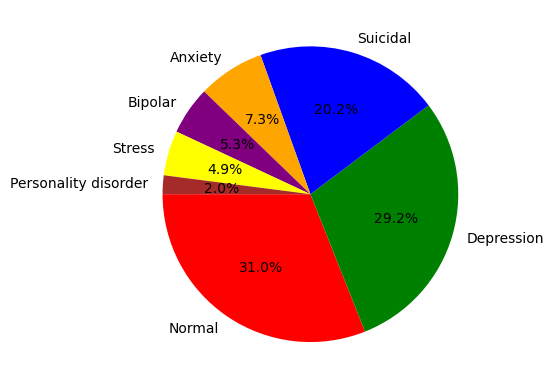

In [124]:
#data is skewed so will need to fix that at some point, shown as pie chart
colors =  ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'brown'] 
plt.pie(s_count, labels=s_count.index, autopct='%.1f%%', colors=colors, startangle=180)
random_statements = df.groupby("status")["statement"].apply(lambda x: x.sample(n=1)) #this prevents a random print for some reason

   
#status: ('Suicidal', 36299) isnt suicidal, sh
#statement: @realDonaldTrump It already is! At least in France one doesn't die/loss everything when get sick &amp; have at least 1â¦ https://t.co/QYN3ku1Q8T

In [125]:
df['sentence_count'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))
df[['num_chars', 'sentence_count']].describe()

,num_chars,sentence_count
count,52681.000000,52681.000000
mean,578.713863,6.280215
std,846.269078,10.688388
min,2.000000,1.000000
25%,80.000000,1.000000
50%,317.000000,3.000000
75%,752.000000,8.000000
max,32759.000000,1260.000000


In [126]:
#get random values for each of the status types as examples
random_statements = df.groupby("status")["statement"].apply(lambda x: x.sample(n=1))
for status, statement in random_statements.items():
    print(f"status: {status}")
    print(f"statement: {statement}", end="\n\n-----------------------------------------------\n")

status: ('Anxiety', 51880)
statement: Please help! Hey guys, I have an on-site interview after being a complete depressed, socially angst hermit for the last 6 months. When I say I didn’t go out of my house more than 4 times in 6 months, best believe it😂 
I applied for a job and I have to fly to another state for it. I thought things were getting better with me but my anxiety is through the roof just thinking about the travel, but mostly the interview. It’s a 2hour session from 10-12pm. 
I usually take 10 mg of propranolol, but I don’t think it ll be enough. Do you guys think it’s ok to take 20mg. Before you ask me to ask my doctor, he said I should take 10-20 mg but I have never taken 20 mg before and I am scared I ll pass out or I won’t be able to breath (had asthma when I was younger). 
I was thinking maybe of taking one at 8am and then another at 9.30am-ish. 
What do you guys think? Anyone with experience? 
Also I m a “little” female despite being in my mid 30s . 5 feet and 110lbs


In [127]:
import re
#convert the statements all to lower case to keep tokenization consistent
df['statement'] = df['statement'].str.lower()
#remove puncuation, markdown, urls, special chars
def remove_special_inputs(text):
    text = re.sub(r"http[s]?://\S+","",text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', "", text)
    # Remove handles (that start with '@')
    text = re.sub(r"@\w+","",text)
    # Remove punctuation and other special characters
    text = re.sub(r"[^\w\s]","",text)
    return text
df['statement_no_punc'] = df['statement'].apply(remove_special_inputs)
df.head()


,Unnamed: 0,statement,status,num_chars,sentence_count,statement_no_punc
0,0,oh my gosh,Anxiety,10,1,oh my gosh
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...
2,2,"all wrong, back off dear, forward doubt. stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...
3,3,i've shifted my focus to something else but i'...,Anxiety,61,1,ive shifted my focus to something else but im ...
4,4,"i'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...


In [128]:
#need to tokenize each the elements in the statement column of the data
#use the word_tokenize from nltk to divide the string into individual words
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['tokens'] = df['statement_no_punc'].apply(lambda x: remove_stopwords(x))
df.sample(5)


,Unnamed: 0,statement,status,num_chars,sentence_count,statement_no_punc,tokens
31900,31900,do you believe in god?,Normal,22,1,do you believe in god,believe god
3741,3741,o debut da yuqi vai ser pop rock,Normal,32,1,o debut da yuqi vai ser pop rock,debut da yuqi vai ser pop rock
32789,32789,he's been in jail three times already.,Normal,38,1,hes been in jail three times already,hes jail three times already
42256,42256,man tax suck i m horrified that i did somethin...,Normal,125,1,man tax suck i m horrified that i did somethin...,man tax suck horrified something wrong turbota...
16452,16452,"sorry if this is an unoriginal post, but i hav...",Depression,389,4,sorry if this is an unoriginal post but i have...,sorry unoriginal post noticed evertime get dru...


In [129]:
df.sample(5)
df.shape

(52681, 7)

In [130]:


#data augmentation to increase data set size, do this by
#translating it to another language and then back
#kind of like how on google translate it may not exactly translate
#Original Text: "The cat is on the mat."
#Translated to French: "Le chat est sur le tapis."
#Back Translated to English: "The cat is on the carpet."
# can add this in later
def augment(text):
    try:
        blob = TextBlob(text)
        translate = blob.translate(to='fr').translate(to='en')
        return str(translate)
    except:
        return text
df['augment_statement'] = df['statement'].apply(augment)
augmented_df = df[['statement', 'status']].copy()
augmented_df['statement'] = df['augment_statement']
df = pd.concat([df, augmented_df])
df.head()
df.shape


    

(105362, 8)

In [131]:
df['statement_no_punc'] = df['statement'].apply(remove_special_inputs)
df['tokens'] = df['statement_no_punc'].apply(lambda x: remove_stopwords(x))
df.head()
df.shape

(105362, 8)

In [132]:
#need to stem the the tokens to eliminate prefix and suffixes to get the root word
#this will standardize the words used in the training data for the model, 
#this takes about a minute to run fyi
stemmer = PorterStemmer() #initialize stemmer

def token_stemming(tokens):
  return ''.join(stemmer.stem(str(token)) for token in tokens)

df['tokens_stem'] = df['tokens'].apply(token_stemming)

df.sample(5)

,Unnamed: 0,statement,status,num_chars,sentence_count,statement_no_punc,tokens,augment_statement,tokens_stem
2025,NaN,how to make old people realize that working un...,Normal,NaN,NaN,how to make old people realize that working un...,make old people realize working underpaid gov ...,NaN,make old people realize working underpaid gov ...
3276,3276.0,chataaa,Normal,7.0,1.0,chataaa,chataaa,chataaa,chataaa
2858,NaN,yes it turns out hahahahaha,Normal,NaN,NaN,yes it turns out hahahahaha,yes turns hahahahaha,NaN,yes turns hahahahaha
20657,20657.0,my vaccination turn is came but cannot decide ...,Suicidal,147.0,3.0,my vaccination turn is came but cannot decide ...,vaccination turn came decide get pretty suicid...,my vaccination turn is came but cannot decide ...,vaccination turn came decide get pretty suicid...
49097,49097.0,feeling overwhelmed? it takes more to overwhel...,Stress,2649.0,35.0,feeling overwhelmed it takes more to overwhelm...,feeling overwhelmed takes overwhelm people oth...,feeling overwhelmed? it takes more to overwhel...,feeling overwhelmed takes overwhelm people oth...


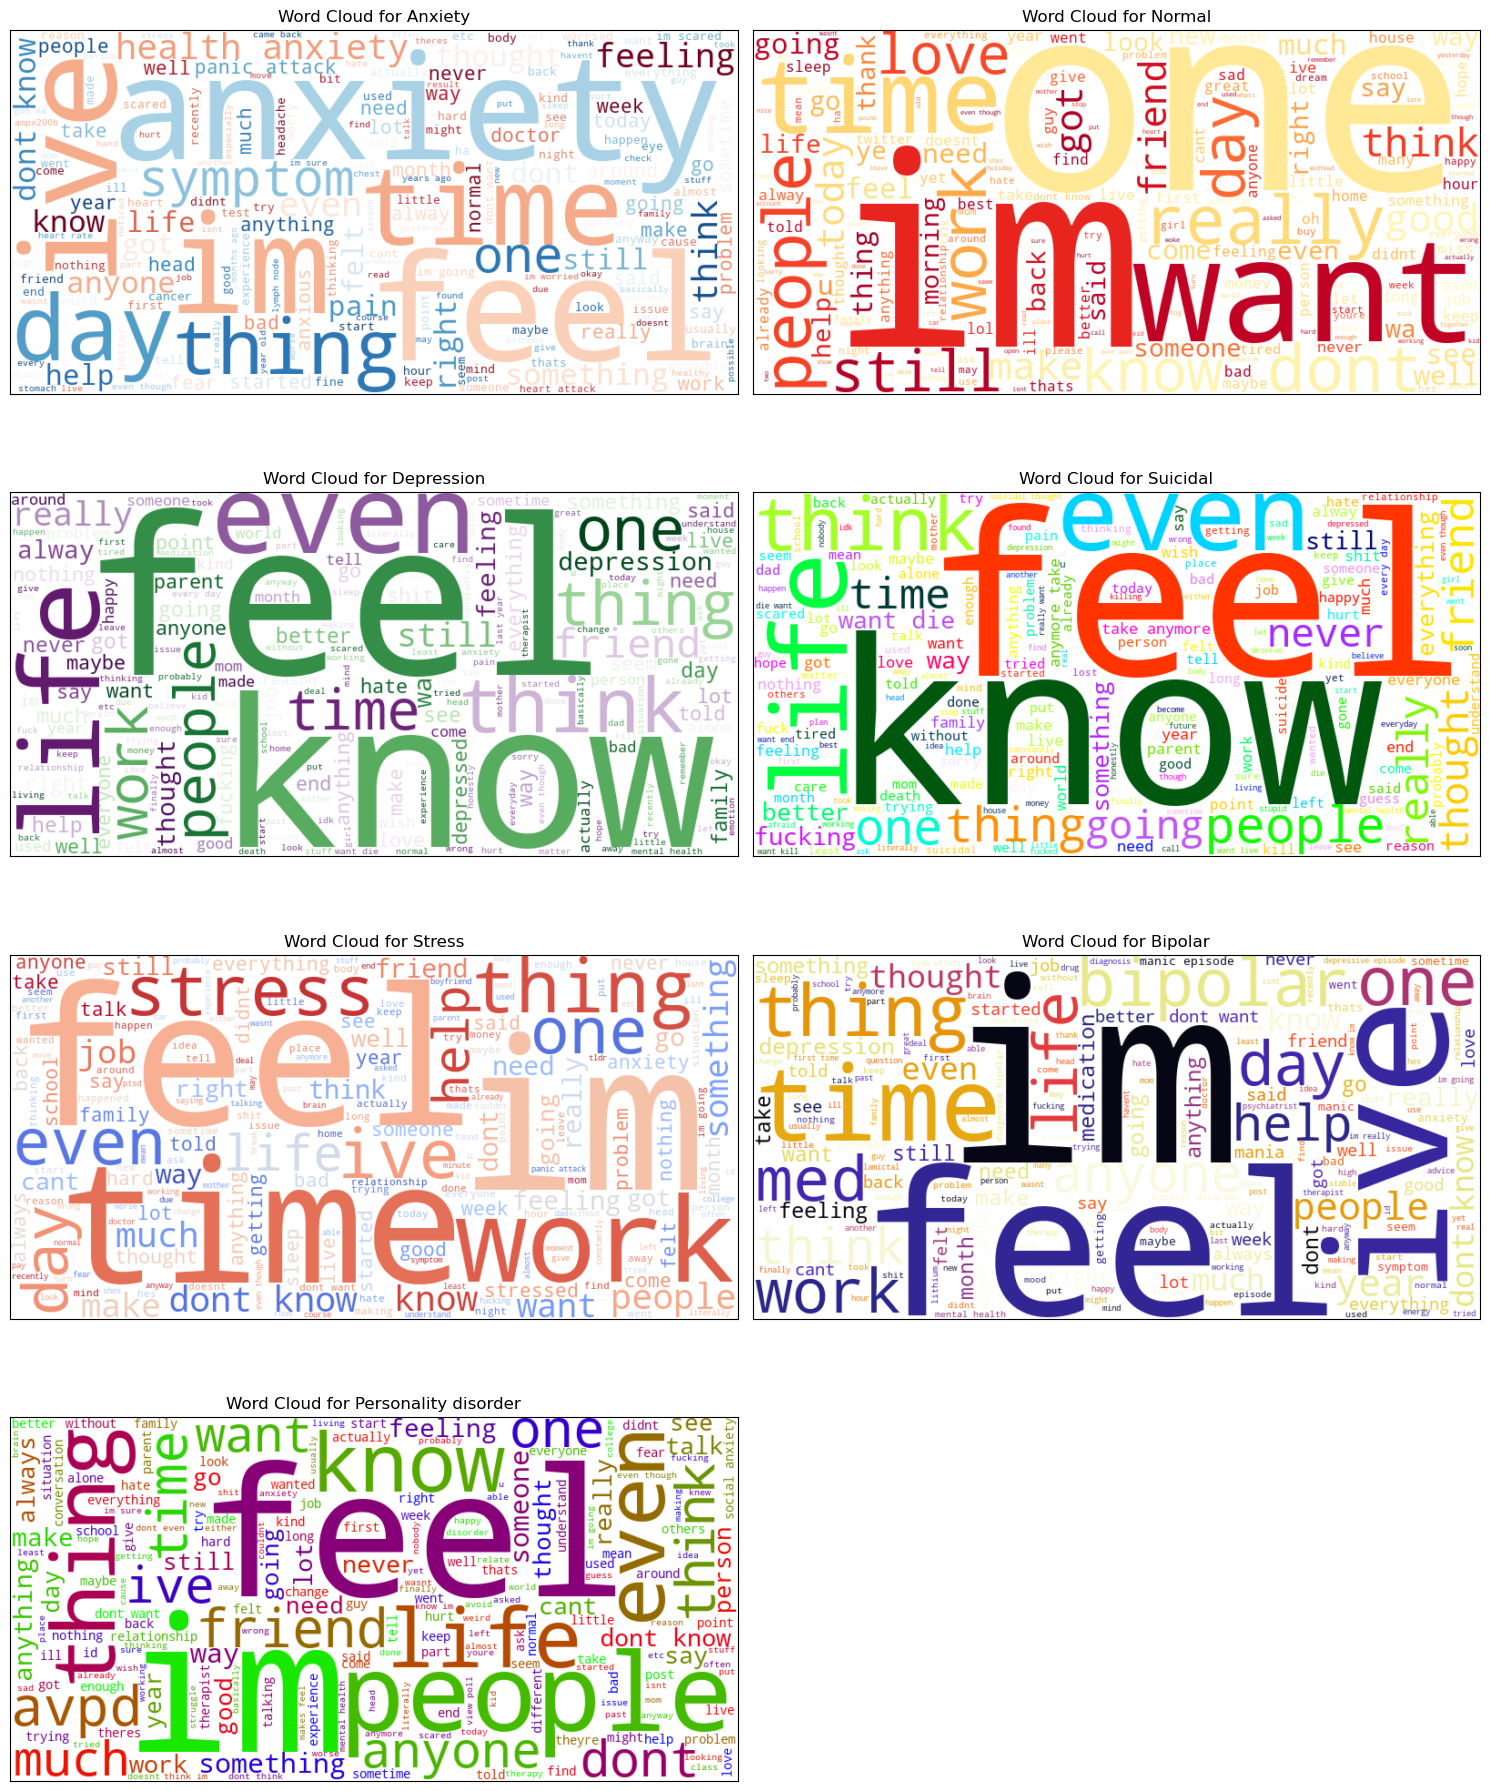

In [133]:
#word collages can help show the common words for each condition
#colormap =  RdBu

unique_status = df['status'].unique()
plt.figure(figsize=(15, 45))
color_map_array = ['RdBu', 'YlOrRd', 'PRGn_r','gist_ncar_r', 'coolwarm', 'CMRmap', 'brg']
for i, status in enumerate(unique_status):
  tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ''.join(x)).tolist())
  word_cloud = WordCloud(width=800, height=400, background_color='white', colormap=color_map_array[i]).generate(tokens_data)
  axes = plt.subplot(len(unique_status) // 2 + 1, 2, i+1)
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.title(f'Word Cloud for {status}')
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=-.85)
plt.show()


In [134]:
#set the x values we will be examining, the stemmed tokens, word and, char count
#we compare these against the status as the y values
x = df[['tokens_stem', 'num_chars', 'sentence_count']]
y = df['status']
print(y)


0        Anxiety
1        Anxiety
2        Anxiety
3        Anxiety
4        Anxiety
          ...   
53038    Anxiety
53039    Anxiety
53040    Anxiety
53041    Anxiety
53042    Anxiety
Name: status, Length: 105362, dtype: object


In [135]:
#encode the y values, status, to be represented as numerical values. turn anxiety to 0
#IF YOU GET AN ERROR RUNNING THIS, RUN THE CELL ABOVE AND TRY AGAIN, IF THIS FAILS IT OVERWRITES Y AND 
#PULLS A JUPYTER NOTEBOOK MOMENT WHERE Y SHOULDNT BE MODIFIED BUT AGAIN JUPYTER NOTEBOOKS 🤬
#encoder = LabelEncoder()
#y = encoder.fit_transform(y.values)
#print(y)


In [136]:
#we use train_test_split function on data
#idk when you are supposed to use a new cell in jupyter notebook typically
#im just doing it after doing an operation or function on some data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)

In [137]:
#now we will convert the text to features 
#we do this via tfidf or Term Frequency-Inverse Document Frequency
#we determine how important a given word is to a status by determining the frequency of a word in the TOTAL dataset
#if word t in data set d the term frequency is equal to (num of t) / (num of words in d)
vector = TfidfVectorizer(max_features=10000)
x_train_tfid = vector.fit_transform(x_train['tokens_stem'])
x_test_tfid = vector.transform(x_test['tokens_stem'])

#now need the numerical features of the training and testing data
x_train_num = x_train[['num_chars', 'sentence_count']].values
x_test_num = x_test[['num_chars', 'sentence_count']].values

#lastly combine the tfid with the numerical values
combined_x_train = hstack([x_train_tfid, x_train_num])
combined_x_test = hstack([x_test_tfid, x_test_num])

print('feature word count: ', len(vector.get_feature_names_out())) #should be 50000
combined_x_train.shape #should be 42144, 50002

feature word count:  10000


(84289, 10002)

In [138]:
#this takes about 10 minutes to run with max_features = 50000, change the max_features to 10k (in above cell) for it to be about 4 minutes
param_grid = {
    'C' : [.01, .1, 1, 10, 100]
}
model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_tfid, y_train)
best_model = grid_search.best_estimator_


In [139]:
y_pred = best_model.predict(x_test_tfid)

In [140]:
print('Best param_grid value(s): ', grid_search.best_params_)
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Classification_report:')
print(classification_report(y_test, y_pred))


Best param_grid value(s):  {'C': 100}
Accuracy score:  0.8870118160679542
Classification_report:
                      precision    recall  f1-score   support

             Anxiety       0.95      0.95      0.95      1523
             Bipolar       0.97      0.96      0.96      1109
          Depression       0.84      0.84      0.84      6204
              Normal       0.96      0.97      0.96      6505
Personality disorder       0.98      0.96      0.97       424
              Stress       0.94      0.91      0.92      1080
            Suicidal       0.78      0.78      0.78      4228

            accuracy                           0.89     21073
           macro avg       0.92      0.91      0.91     21073
        weighted avg       0.89      0.89      0.89     21073



In [141]:
cm = confusion_matrix(y_test, y_pred)
fig = ff.create_annotated_heatmap(
    z=cm,
    x=list(set(y_test)),
    y=list(set(y_test)),
    annotation_text=cm,
    colorscale='Viridis'
)
fig.update_layout(title='Confusion Matrix')
fig.show()


In [142]:
#was using this for xgb but not needed anymore without xgb
#now need random sampling
#r = RandomOverSampler(random_state=42)
#x_train_r, y_train_r = r.fit_resample(combined_x_train, y_train)
#x_train_r.shape

In [143]:
#i gave up on this bc after 30 minutes it still hadnt finished
#this is a gradient booster algorithm.
#idk what it actually does bc ML seems to just be importing modules to
#the machine learning part
#xgb_clf = XGBClassifier(learing_rate=.5, max_depth =7, n_estimators=500, random_state=42, tree_method ="hist")
#xgb_clf.fit(x_train_r, y_train_r)
#y_pred = xgb_clf.predict(combined_x_test)

#xgb_clf = XGBClassifier(learning_rate=0.5, max_depth=7, n_estimators=500, random_state=101, n_jobs=-1)
# Train the classifier on the resampled training data
#xgb_clf.fit(x_train_r, y_train_r)
# Predict the labels on the test data
#y_pred = xgb_clf.predict(combined_x_test)